In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/ubuntu/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.627134,0.993848,00:00
1,0.849302,0.674024,00:00
2,0.639775,0.665579,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [9]:
path=Config.data_path()/'ml-100k'

In [10]:
path

PosixPath('/home/ubuntu/.fastai/data/ml-100k')

In [11]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
len(ratings)

100000

In [14]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [15]:
doc(CollabDataBunch.from_df)

In [16]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [17]:
data.show_batch()

userId,title,target
934,Independence Day (ID4) (1996),3.0
561,"Third Man, The (1949)",3.0
807,Aladdin (1992),4.0
6,Contact (1997),2.0
387,Twelfth Night (1996),3.0


In [18]:
y_range = [0,5.5]

In [19]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


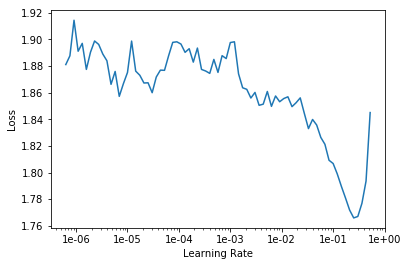

In [21]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [22]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.961030,0.943980,00:07
1,0.884285,0.881657,00:07
2,0.771858,0.839402,00:07
3,0.669183,0.818262,00:07
4,0.563098,0.819740,00:07


In [23]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [24]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [25]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [26]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [27]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [28]:
item0 = lambda o:o[0]

In [29]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3363),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2957),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2885), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2678), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2588), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2548), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2364), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2344), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2299), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2280), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2249), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2065), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2045), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2039), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2028), 'Free Willy 3: T

In [30]:
sorted(movie_ratings, key=item0, reverse=True)[:15]

[(tensor(0.6006), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5970), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5673), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5626), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5460), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5367), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5138), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5060), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4985), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4950), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4900), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4864), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4832), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4767), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4691), 'Casablanca (1942)', 4.45679012345679)]

### Movie weights

In [31]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [32]:
print(top_movies[3])
movie_w[:1]

Return of the Jedi (1983)


tensor([[-0.0264, -0.3060, -0.4367, -0.2757, -0.1313,  0.1422,  0.3525,  0.4063,
          0.3958, -0.0540,  0.1394,  0.3082,  0.7441,  0.0744,  0.0889, -0.2732,
          0.2443, -0.2453,  0.2111, -0.3708, -0.2534, -0.2442,  0.0534,  0.4219,
         -0.6475,  0.0391,  0.2707,  0.3023,  0.3317,  0.0746, -0.3987,  0.6340,
         -0.2126,  0.4758, -0.1021, -0.3620,  0.3135,  0.0208,  0.5286, -0.2395]])

In [33]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [34]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [35]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1106), 'Close Shave, A (1995)'),
 (tensor(1.0957), 'Casablanca (1942)'),
 (tensor(1.0571), 'Wrong Trousers, The (1993)'),
 (tensor(1.0015), 'Third Man, The (1949)'),
 (tensor(0.9892), 'Chinatown (1974)'),
 (tensor(0.9676), 'Lawrence of Arabia (1962)'),
 (tensor(0.9676), 'When We Were Kings (1996)'),
 (tensor(0.9607), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9521), 'North by Northwest (1959)'),
 (tensor(0.9501), 'Persuasion (1995)')]

In [36]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3039), 'Home Alone 3 (1997)'),
 (tensor(-1.2369), 'Jungle2Jungle (1997)'),
 (tensor(-1.2206), "McHale's Navy (1997)"),
 (tensor(-1.1907), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1458), 'Leave It to Beaver (1997)'),
 (tensor(-1.1256), 'Bio-Dome (1996)'),
 (tensor(-1.1216), 'Congo (1995)'),
 (tensor(-1.0964), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0797), 'Speed 2: Cruise Control (1997)'),
 (tensor(-1.0495), 'Batman & Robin (1997)')]

In [37]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [38]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1647), 'Braveheart (1995)'),
 (tensor(1.1129), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0729), 'Titanic (1997)'),
 (tensor(0.9286), 'Forrest Gump (1994)'),
 (tensor(0.9181), 'Independence Day (ID4) (1996)'),
 (tensor(0.8820), 'Star Wars (1977)'),
 (tensor(0.8680), "It's a Wonderful Life (1946)"),
 (tensor(0.8509), 'Indiana Jones and the Last Crusade (1989)'),
 (tensor(0.8479), 'Air Force One (1997)'),
 (tensor(0.8450), 'Top Gun (1986)')]

In [39]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8558), 'Stupids, The (1996)'),
 (tensor(-0.8223), 'Keys to Tulsa (1997)'),
 (tensor(-0.8061), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7674), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7565), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7324), 'Cable Guy, The (1996)'),
 (tensor(-0.7234), 'Jude (1996)'),
 (tensor(-0.7167), 'Trainspotting (1996)'),
 (tensor(-0.7056), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7048), 'Heavenly Creatures (1994)')]

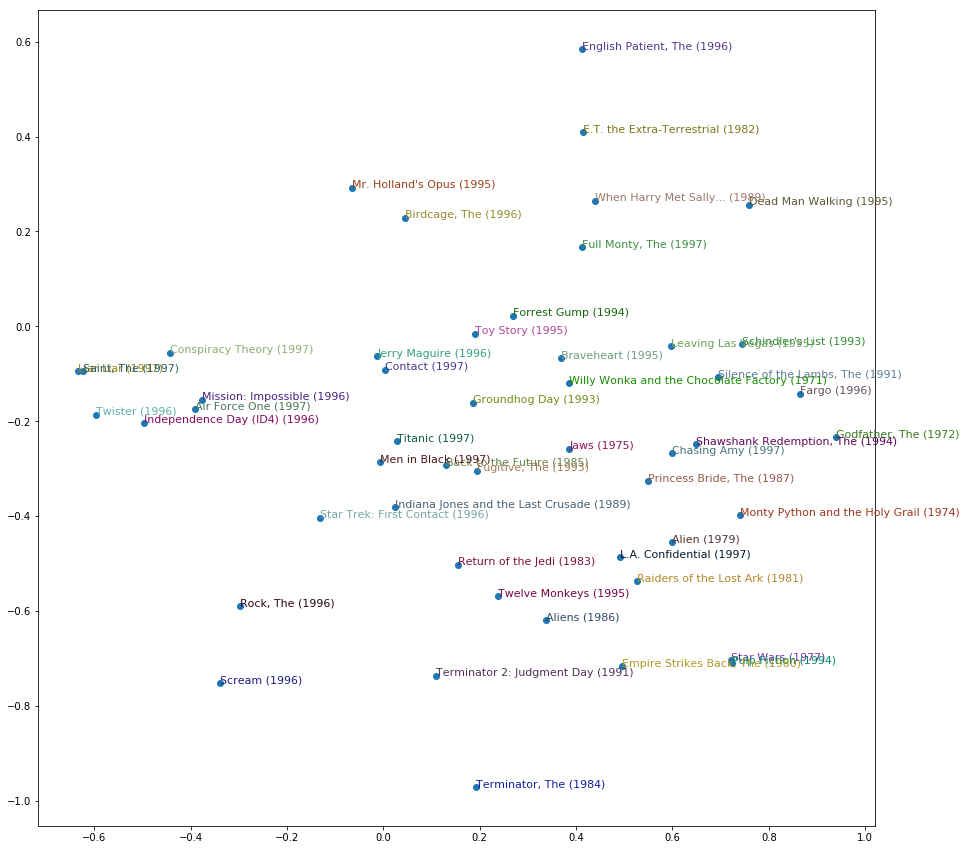

In [40]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()